In [1]:
!kaggle datasets download -d vishalsubbiah/pokemon-images-and-types


  0%|          | 0.00/2.47M [00:00<?, ?B/s]
 41%|████      | 1.00M/2.47M [00:00<00:00, 9.67MB/s]
 81%|████████  | 2.00M/2.47M [00:00<00:00, 9.47MB/s]
100%|██████████| 2.47M/2.47M [00:00<00:00, 10.2MB/s]
'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [8]:
import cv2
import os
import numpy as np

images = []
path = "pokemon-images-and-types\images\images"
for filename in os.listdir(path):
  img = cv2.imread(os.path.join(path,filename))
  if img is not None:
    images.append(cv2.resize(img, (80, 80)))

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.layers import Input, Dense, MaxPooling2D, Conv2D, Dropout, UpSampling2D
from keras.models import Sequential, Model, load_model

In [10]:
X = np.array(images)
X = X/255
np.random.shuffle(X)
X_train, X_test, X_validation  = X[:round(len(X)*.8),:,:], X[:round(len(X)*.8):round(len(X)*.9),:,:], X[:round(len(X)*.9):,:,:]
X.shape

(809, 80, 80, 3)

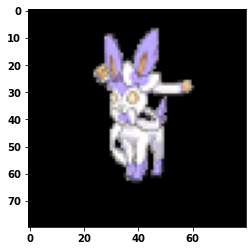

In [11]:
plt.imshow(X[0,:,:,:])

In [12]:
X_train_gray = np.empty_like(X_train)
X_train_gray[:,:,:,0]=X_train[:,:,:,0]*0.299 +X_train[:,:,:,1]*0.587 +X_train[:,:,:,2]*0.114
X_train_gray[:,:,:,1]=X_train_gray[:,:,:,0]
X_train_gray[:,:,:,2]=X_train_gray[:,:,:,0]

X_val_gray = np.empty_like(X_validation)
X_val_gray[:,:,:,0]=X_validation[:,:,:,0]*0.299 +X_validation[:,:,:,1]*0.587 +X_validation[:,:,:,2]*0.114
X_val_gray[:,:,:,1]=X_val_gray[:,:,:,0]
X_val_gray[:,:,:,2]=X_val_gray[:,:,:,0]

X_test_gray = np.empty_like(X_test)
X_test_gray[:,:,:,0]=X_test[:,:,:,0]*0.299 +X_test[:,:,:,1]*0.587 +X_test[:,:,:,2]*0.114
X_test_gray[:,:,:,1]=X_test_gray[:,:,:,0]
X_test_gray[:,:,:,2]=X_test_gray[:,:,:,0]

def gray(X):
  X_gray = np.empty_like(X)
  X_gray[:,:,:,0]=X[:,:,:,0]*0.299 +X[:,:,:,1]*0.587 +X[:,:,:,2]*0.114
  X_gray[:,:,:,1]=X_gray[:,:,:,0]
  X_gray[:,:,:,2]=X_gray[:,:,:,0]
  return X_gray

In [13]:

inputs1 = Input(shape=(80, 80, 3))
encoder_output = Conv2D(64, (3,3), activation='relu', padding='same', strides=2)(inputs1)
encoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(128, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)

# decoder

decoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(encoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(64, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(32, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = Conv2D(16, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = Conv2D(3, (3, 3), activation='tanh', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
    
model_pdf = Model(inputs=inputs1, outputs=decoder_output)
model_pdf.compile(loss ='mean_squared_error', optimizer ='adam', metrics=['acc'])
input_shape = [(None, 80, 80, 3)]
model_pdf.build(input_shape)

model_pdf.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 80, 80, 3)]       0         
                                                                 
 conv2d_13 (Conv2D)          (None, 40, 40, 64)        1792      
                                                                 
 conv2d_14 (Conv2D)          (None, 40, 40, 128)       73856     
                                                                 
 conv2d_15 (Conv2D)          (None, 20, 20, 128)       147584    
                                                                 
 conv2d_16 (Conv2D)          (None, 20, 20, 256)       295168    
                                                                 
 conv2d_17 (Conv2D)          (None, 10, 10, 256)       590080    
                                                                 
 conv2d_18 (Conv2D)          (None, 10, 10, 512)       1180

In [18]:
model_pdf = load_model("model.h5")
assert isinstance(model_pdf, Model)
model_pdf.fit(X_train_gray, X_train, epochs=15, batch_size = 20)

Epoch 1/15
33/33 [==============================] - 35s 1s/step - loss: 0.0065 - acc: 0.3580
Epoch 2/15
33/33 [==============================] - 35s 1s/step - loss: 0.0060 - acc: 0.3597
Epoch 3/15
33/33 [==============================] - 36s 1s/step - loss: 0.0058 - acc: 0.3548
Epoch 4/15
33/33 [==============================] - 37s 1s/step - loss: 0.0054 - acc: 0.3208
Epoch 5/15
33/33 [==============================] - 39s 1s/step - loss: 0.0052 - acc: 0.2574
Epoch 6/15
33/33 [==============================] - 35s 1s/step - loss: 0.0050 - acc: 0.3510
Epoch 7/15
33/33 [==============================] - 37s 1s/step - loss: 0.0048 - acc: 0.3099
Epoch 8/15
33/33 [==============================] - 37s 1s/step - loss: 0.0047 - acc: 0.3433
Epoch 9/15
33/33 [==============================] - 37s 1s/step - loss: 0.0046 - acc: 0.3137
Epoch 10/15
33/33 [==============================] - 38s 1s/step - loss: 0.0045 - acc: 0.3131
Epoch 11/15
33/33 [==============================] - 37s 1s/step - lo

23/23 [==============================] - 9s 373ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


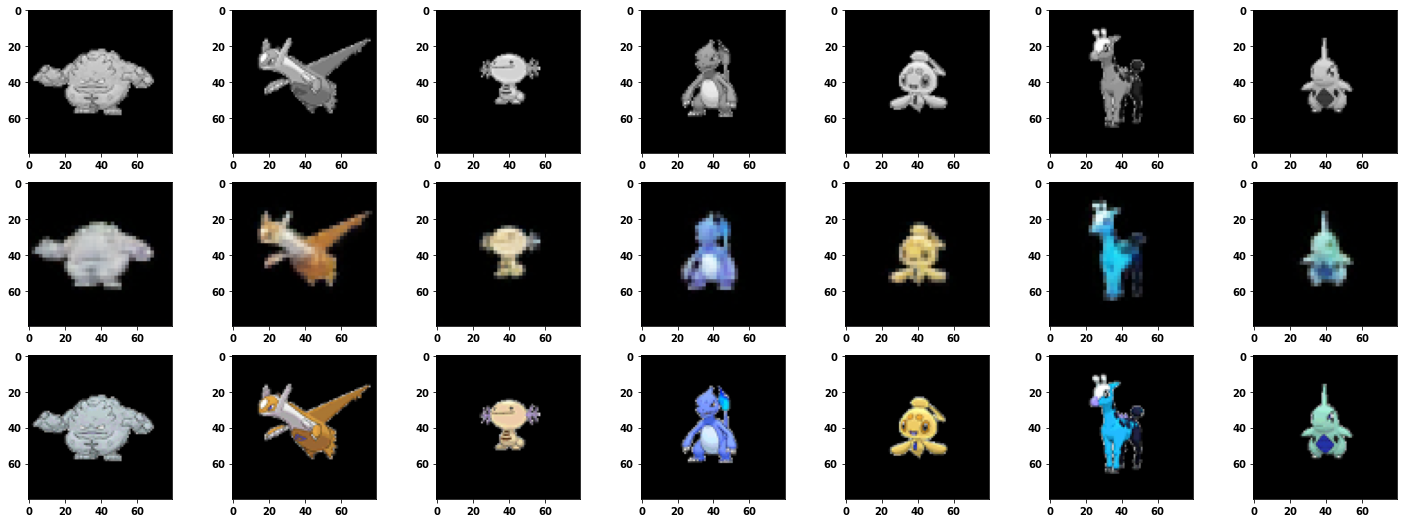

In [17]:
import random as rd
X_predicted = model_pdf.predict(X_val_gray)
n = 7
id=rd.randint(0,len(X_val_gray)-n)
fig, axs = plt.subplots(3, n, figsize=(25, 9))
for i in range(n):
  axs[0][i].imshow(X_val_gray[id+i, :, :, :])
  axs[1][i].imshow(X_predicted[id+i, :, :, :])
  axs[2][i].imshow(X_validation[id+i, :, :, :])